In [2]:
from game2048.game import Game
from game2048.displays import Display, IPythonDisplay
import numpy as np
#from game2048.agents import ExpectiMaxAgent

display1 = Display()
display2 = IPythonDisplay()

In [3]:
class Agent_train:
    '''Agent Base.'''

    def __init__(self, game, display=None):
        self.game = game
        self.display = display

    def play(self, max_iter=np.inf, verbose=False):
        n_iter = 0
        while (n_iter < max_iter) and (not self.game.end):
            direction = self.step()
            self.game.move(direction)
            n_iter += 1
            if verbose:
                print("Iter: {}".format(n_iter))
                print("======Direction: {}======".format(
                    ["left", "down", "right", "up"][direction]))
                if self.display is not None:
                    self.display.display(self.game)

    def step(self):
        direction = int(input("0: left, 1: down, 2: right, 3: up = ")) % 4
        return direction


class ExpectiMaxAgent_train(Agent_train):

    def __init__(self, game, display=None):
        if game.size != 4:
            raise ValueError(
                "`%s` can only work with game of `size` 4." % self.__class__.__name__)
        super().__init__(game, display)
        from game2048.expectimax import board_to_move
        self.search_func = board_to_move
        self.data = []

    def step(self):
        direction = self.search_func(self.game.board)
        self.data.append([game.board, direction])
        return direction

In [54]:
%%time
data = []

for i in range(2000):
    game = Game(4, score_to_win=512, random=False)
    agent = ExpectiMaxAgent_train(game, display=display2)
    agent.play(verbose=False)
    data.extend(agent.data)
    if i % 100 == 0 and i: print(i)
print(len(data))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
373966
CPU times: user 1h 21min 28s, sys: 14.1 s, total: 1h 21min 42s
Wall time: 29min 33s


In [55]:
data_backup = data

In [56]:
from sklearn.model_selection import train_test_split
print(len(data))
print(data[np.random.randint(0, len(data))])
  

data_x = []
data_y = []
for x, y in data:
    data_x.append(x)
    data_y.append(y)

data_x = np.log2(np.maximum(data_x, 1))
X_train, X_test, Y_train, Y_test = train_test_split(
    data_x, data_y, test_size=0.05)

373966
[array([[  2.,   4.,   0.,   0.],
       [  4.,   8.,   0.,   0.],
       [ 32.,  32.,   4.,   8.],
       [128.,   4.,   2.,   4.]]), 0]


In [57]:
np.save("data_512_big.npy", data)

In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D, Activation, concatenate, LeakyReLU

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
tf.device = '/GPU:0'
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11360489088873896681,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1416432435
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10991599060808570974
 physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [79]:
(X_train, X_test, Y_train, Y_test) = np.load("data_8192_big.npy", allow_pickle=True)

In [80]:
X_train = np.array(X_train).reshape(len(X_train), 4, 4, 1)
X_test = np.array(X_test).reshape(len(X_test), 4, 4, 1)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

NUM_Y_CLASSES = 4
NUM_X_CLASSES = 14

X_train = keras.utils.np_utils.to_categorical(
    X_train.reshape(X_train.shape[0], -1), NUM_X_CLASSES)
X_test = keras.utils.np_utils.to_categorical(
    X_test.reshape(X_test.shape[0], -1), NUM_X_CLASSES)
Y_train = keras.utils.np_utils.to_categorical(Y_train, NUM_Y_CLASSES)
Y_test = keras.utils.np_utils.to_categorical(Y_test, NUM_Y_CLASSES)
X_train = X_train.reshape(X_train.shape[0], 4, 4, NUM_X_CLASSES)
X_test = X_test.reshape(X_test.shape[0], 4, 4, NUM_X_CLASSES)

print(X_train.shape, X_test.shape)
print(Y_train.shape)

(14880730, 4, 4, 14) (50000, 4, 4, 14)
(14880730, 4)


In [3]:
NUM_Y_CLASSES = 4
NUM_X_CLASSES = 14


input_img = Input(shape=(4, 4, NUM_X_CLASSES))
FILTERS = 64
Conv41 = Conv2D(FILTERS, (4, 1), padding='same', kernel_initializer='he_normal')(input_img)
Conv14 = Conv2D(FILTERS, (1, 4), padding='same', kernel_initializer='he_normal')(input_img)
Conv44 = Conv2D(FILTERS, (4, 4), padding='same', kernel_initializer='he_normal')(input_img)
Conv_layer = concatenate([Conv41, Conv14, Conv44], axis = -1)       


x = Flatten()(Conv_layer)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dense(units=512, kernel_initializer='he_normal')(x)
x = Activation('relu')(x)

x = BatchNormalization()(x)
x = Dense(units=512, kernel_initializer='he_normal')(x)
x = Activation('relu')(x)

#model.add(BatchNormalization())

outputs = Dense(units=4, activation='softmax')(x)

model = Model(input_img, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])
model.summary()
history = []
history_acc = []
history_los = []

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 4, 14)     0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 64)     3648        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     3648        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 4, 4, 64)     14400       input_1[0][0]                    
____________________________________________________________________________________________

Train on 14880730 samples, validate on 50000 samples
Epoch 1/15
14880730/14880730 [==============================] - 240s 16us/step - loss: 0.7765 - accuracy: 0.6277 - val_loss: 0.7047 - val_accuracy: 0.6649

Epoch 00001: val_loss improved from inf to 0.70470, saving model to model_Conv_8192_best7.h5
Epoch 2/15
14880730/14880730 [==============================] - 239s 16us/step - loss: 0.6764 - accuracy: 0.6815 - val_loss: 0.6551 - val_accuracy: 0.6924

Epoch 00002: val_loss improved from 0.70470 to 0.65513, saving model to model_Conv_8192_best7.h5
Epoch 3/15
14880730/14880730 [==============================] - 239s 16us/step - loss: 0.6388 - accuracy: 0.7028 - val_loss: 0.6354 - val_accuracy: 0.7077

Epoch 00003: val_loss improved from 0.65513 to 0.63541, saving model to model_Conv_8192_best7.h5
Epoch 4/15
14880730/14880730 [==============================] - 239s 16us/step - loss: 0.6135 - accuracy: 0.7169 - val_loss: 0.6187 - val_accuracy: 0.7140

Epoch 00004: val_loss improved from 

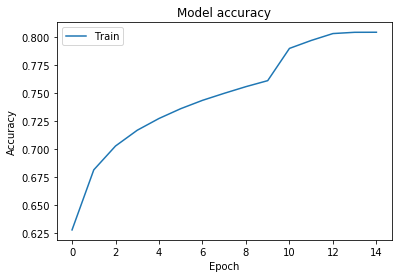

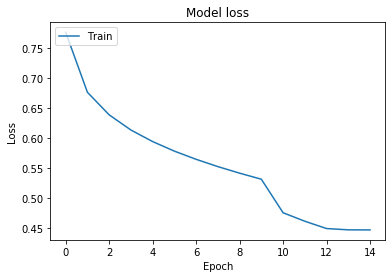

CPU times: user 1h 9min 33s, sys: 5min 5s, total: 1h 14min 39s
Wall time: 59min 55s


In [150]:
%%time
import matplotlib.pyplot as plt

Reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', min_delta=0.0001)
checkpointer = ModelCheckpoint(filepath='model_Conv_8192_best7.h5', verbose=1, save_best_only=True)
#model = load_model('my_model2.h5')
'''for i in range(100):
    history = model.fit(X_train, Y_train, epochs=5, batch_size=128, verbose=0)
    # evaluate
    print('In episode %2d:' % (i))
    loss_train, score_train = model.evaluate(X_train, Y_train)
    print('Training loss: %.4f, Training accuracy: %.2f%%' %
          (loss_train, score_train * 100))
    loss_test, score_test = model.evaluate(X_test, Y_test)
    print('Testing loss: %.4f, Testing accuracy: %.2f%%' %
          (loss_test, score_test * 100))
    print()
'''
history = model.fit(X_train, Y_train, epochs=15, batch_size=512, verbose=1, validation_data=(X_test, Y_test), 
                   callbacks=[Reduce_lr, checkpointer]).history
history_acc.extend(history['accuracy'])
history_los.extend(history['loss'])
'''loss_train, score_train = model.evaluate(X_train, Y_train)
print('Training loss: %.4f, Training accuracy: %.2f%%' %
      (loss_train, score_train * 100))'''
loss_test, score_test = model.evaluate(X_test, Y_test)
print('Testing loss: %.4f, Testing accuracy: %.2f%%' %
      (loss_test, score_test * 100))

#print(history)
print('Total training episode: %d\n' % len(history_acc))
plt.plot(history_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_los)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show() 

In [151]:
from game2048.agents import Agent

#NUM_X_CLASSES = 14
class MyAgent(Agent):

    def step(self):
        board = np.log2(np.maximum(np.array(self.game.board), 1)).reshape(1, 4, 4, 1)
        board = keras.utils.np_utils.to_categorical(board, NUM_X_CLASSES)
        direction = np.argmax(model.predict(board), axis=1)
        return direction

Average scores: @50 times 957.44
Scores in one std: 438.30 -- 1476.58


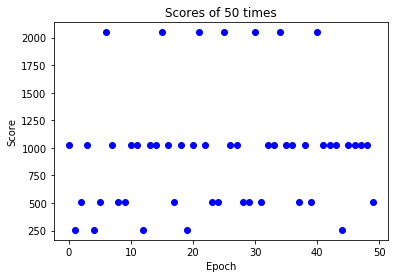

CPU times: user 1min 8s, sys: 3.12 s, total: 1min 11s
Wall time: 50 s


In [152]:
%%time
def single_run(size, score_to_win, AgentClass, **kwargs):
    game = Game(size, score_to_win)
    agent = AgentClass(game, display=Display(), **kwargs)
    agent.play(verbose=False)
    return game.score

N_TESTS = 50
scores = []
for _ in range(N_TESTS):
    score = single_run(4, score_to_win = None, AgentClass=MyAgent)
    scores.append(score)

s_mean = np.mean(scores)
s_std  = np.std(scores)
print("Average scores: @%s times" % N_TESTS, round(s_mean, 2))
print("Scores in one std: %.2f -- %.2f" % (s_mean - s_std, s_mean + s_std))
plt.plot(scores, 'bo')
plt.title('Scores of 50 times')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.show() 

In [153]:
model.save('my_best_DL_2048_model7.h5')

In [8]:
from game2048.agents import Agent

model1 = load_model('my_best_DL_2048_model1.h5')
model2 = load_model('my_best_DL_2048_model2.h5')
model3 = load_model('my_best_DL_2048_model3.h5')
model4 = load_model('my_best_DL_2048_model4.h5')
model5 = load_model('my_best_DL_2048_model5.h5')
model6 = load_model('my_best_DL_2048_model6.h5')
model7 = load_model('my_best_DL_2048_model7.h5')
NUM_X_CLASSES = 14
class MyAgent(Agent):

    def step(self):
        board = np.log2(np.maximum(np.array(self.game.board), 1)).reshape(1, 4, 4, 1)
        board = keras.utils.np_utils.to_categorical(board, NUM_X_CLASSES)
        direction = []
        direction.extend(np.argmax(model1.predict(board), axis=1))
        direction.extend(np.argmax(model2.predict(board), axis=1))
        direction.extend(np.argmax(model3.predict(board), axis=1))
        direction.extend(np.argmax(model4.predict(board), axis=1))
        direction.extend(np.argmax(model5.predict(board), axis=1))
        direction.extend(np.argmax(model6.predict(board), axis=1))
        direction.extend(np.argmax(model7.predict(board), axis=1))
        direction = np.argmax(np.bincount(direction))
        return direction

Average scores: @50 times 1515.52
Scores in one std: 588.47 -- 2442.57


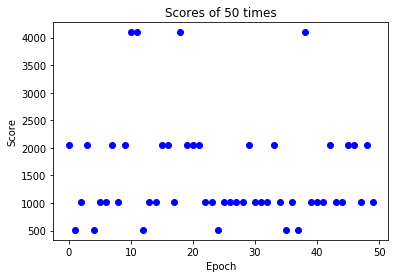

CPU times: user 10min 56s, sys: 37.5 s, total: 11min 33s
Wall time: 7min 37s


In [13]:
%%time
import matplotlib.pyplot as plt

def single_run(size, score_to_win, AgentClass, **kwargs):
    game = Game(size, score_to_win)
    agent = AgentClass(game, display=Display(), **kwargs)
    agent.play(verbose=False)
    return game.score

N_TESTS = 50
scores = []
for _ in range(N_TESTS):
    score = single_run(4, score_to_win = None, AgentClass=MyAgent)
    scores.append(score)

s_mean = np.mean(scores)
s_std  = np.std(scores)
print("Average scores: @%s times" % N_TESTS, round(s_mean, 2))
print("Scores in one std: %.2f -- %.2f" % (s_mean - s_std, s_mean + s_std))
plt.plot(scores, 'bo')
plt.title('Scores of 50 times')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.show() 

In [339]:
%%time
game = Game(4, score_to_win=2048, random=False)
display2.display(game)
agent = MyAgent(game, display=display2)
agent.play(verbose=True)

,,,
,,2,
,,,
4,,,


Iter: 1
======Direction: up======


4,,2,2
,,,
,,,
,,,


Iter: 2
======Direction: down======


,,,
,,4,
,,,
4,,2,2


Iter: 3
======Direction: down======


,,,
,,,
,,4,
4,4,2,2


Iter: 4
======Direction: up======


4,4,4,2
,,2,
,,,
,,2,


Iter: 5
======Direction: left======


8,4,2,
2,,,
4,,,
2,,,


Iter: 6
======Direction: down======


8,,,
2,,,
4,,,
2,4,2,4


Iter: 7
======Direction: up======


8,4,2,4
2,,,
4,,4,
2,,,


Iter: 8
======Direction: up======


8,4,2,4
2,2,4,
4,,,
2,,,


Iter: 9
======Direction: down======


8,2,,
2,,,
4,4,2,
2,2,4,4


Iter: 10
======Direction: down======


8,,,
2,2,4,
4,4,2,
2,2,4,4


Iter: 11
======Direction: up======


8,2,4,4
2,4,2,
4,2,4,
2,,,2


Iter: 12
======Direction: down======


8,,,2
2,2,4,
4,4,2,4
2,2,4,2


Iter: 13
======Direction: down======


8,,,2
2,2,4,2
4,4,2,4
2,2,4,2


Iter: 14
======Direction: left======


8,2,,4
4,4,2,
8,2,4,
4,4,2,


Iter: 15
======Direction: down======


8,2,,
4,4,2,2
8,2,4,
4,4,2,4


Iter: 16
======Direction: down======


8,2,,2
4,4,2,
8,2,4,2
4,4,2,4


Iter: 17
======Direction: up======


8,2,2,4
4,4,4,4
8,2,2,2
4,4,,


Iter: 18
======Direction: up======


8,2,2,8
4,4,4,2
8,2,2,4
4,4,,


Iter: 19
======Direction: left======


8,4,8,4
8,4,2,
8,4,4,
8,,,


Iter: 20
======Direction: left======


8,4,8,4
8,4,2,
8,8,,
8,,,4


Iter: 21
======Direction: left======


8,4,8,4
8,4,2,
16,,,
8,4,,2


Iter: 22
======Direction: left======


8,4,8,4
8,4,2,
16,,2,
8,4,2,


Iter: 23
======Direction: left======


8,4,8,4
8,4,2,
16,2,,
8,4,2,4


Iter: 24
======Direction: up======


16,8,8,8
16,2,4,
8,4,,
,,,2


Iter: 25
======Direction: up======


32,8,8,8
8,2,4,2
,4,,2
,,,


Iter: 26
======Direction: left======


32,16,8,
8,2,4,2
4,2,,4
,,,


Iter: 27
======Direction: up======


32,16,8,2
8,4,4,4
4,,2,
,,,


Iter: 28
======Direction: left======


32,16,8,2
8,8,4,
4,2,,
,,,4


Iter: 29
======Direction: up======


32,16,8,2
8,8,4,4
4,2,,4
,,,


Iter: 30
======Direction: left======


32,16,8,2
16,8,,
4,2,4,
2,,,


Iter: 31
======Direction: up======


32,16,8,2
16,8,4,
4,2,2,
2,,,


Iter: 32
======Direction: left======


32,16,8,2
16,8,4,
4,4,,
2,4,,


Iter: 33
======Direction: up======


32,16,8,2
16,8,4,2
4,8,,
2,,,


Iter: 34
======Direction: right======


32,16,8,2
16,8,4,2
,,4,8
,2,,2


Iter: 35
======Direction: right======


32,16,8,2
16,8,4,2
4,,4,8
,,,4


Iter: 36
======Direction: left======


32,16,8,2
16,8,4,2
8,8,,
4,,,4


Iter: 37
======Direction: up======


32,16,8,4
16,16,4,4
8,4,,
4,,,


Iter: 38
======Direction: left======


32,16,8,4
32,8,,2
8,4,,
4,,,


Iter: 39
======Direction: left======


32,16,8,4
32,8,2,
8,4,,4
4,,,


Iter: 40
======Direction: left======


32,16,8,4
32,8,2,
8,8,,
4,4,,


Iter: 41
======Direction: up======


64,16,8,4
8,16,2,
4,4,2,
,,,


Iter: 42
======Direction: up======


64,32,8,4
8,4,4,
4,,2,
,,,


Iter: 43
======Direction: left======


64,32,8,4
8,8,4,
4,2,,
,,,


Iter: 44
======Direction: left======


64,32,8,4
16,4,,4
4,2,,
,,,


Iter: 45
======Direction: left======


64,32,8,4
16,8,,2
4,2,,
,,,


Iter: 46
======Direction: right======


64,32,8,4
,16,8,2
,,4,2
,,,4


Iter: 47
======Direction: left======


64,32,8,4
16,8,2,
4,2,4,
4,,,


Iter: 48
======Direction: up======


64,32,8,4
16,8,2,
8,2,4,
,,4,


Iter: 49
======Direction: left======


64,32,8,4
16,8,2,2
8,2,4,
4,,,


Iter: 50
======Direction: left======


64,32,8,4
16,8,4,
8,2,4,
4,,4,


Iter: 51
======Direction: up======


64,32,8,4
16,8,8,
8,2,4,
4,,,4


Iter: 52
======Direction: up======


64,32,16,8
16,8,4,
8,2,,
4,4,,


Iter: 53
======Direction: left======


64,32,16,8
16,8,4,
8,2,,
8,,,4


Iter: 54
======Direction: up======


64,32,16,8
16,8,4,4
16,2,2,
,,,


Iter: 55
======Direction: up======


64,32,16,8
32,8,4,4
,2,2,
,2,,


Iter: 56
======Direction: right======


64,32,16,8
,32,8,8
,2,,4
,,,2


Iter: 57
======Direction: left======


64,32,16,8
32,16,,
2,4,4,
2,,,


Iter: 58
======Direction: up======


64,32,16,8
32,16,4,
4,4,4,
,,,


Iter: 59
======Direction: up======


64,32,16,8
32,16,8,
4,4,,
2,,,


Iter: 60
======Direction: left======


64,32,16,8
32,16,8,
8,2,,
2,,,


Iter: 61
======Direction: right======


64,32,16,8
,32,16,8
,4,8,2
,,,2


Iter: 62
======Direction: up======


64,64,32,16
,4,8,4
,,,
,,,4


Iter: 63
======Direction: left======


128,32,16,
4,8,4,
4,,,
4,,,


Iter: 64
======Direction: up======


128,32,16,
8,8,4,
4,,,4
,,,


Iter: 65
======Direction: up======


128,32,16,4
8,8,4,4
4,,,
,,,


Iter: 66
======Direction: up======


128,32,16,8
8,8,4,
4,,,
,4,,


Iter: 67
======Direction: up======


128,32,16,8
8,8,4,
4,4,,2
,,,


Iter: 68
======Direction: up======


128,32,16,8
8,8,4,2
4,4,,
2,,,


Iter: 69
======Direction: left======


128,32,16,8
16,4,2,
8,,,
2,,,2


Iter: 70
======Direction: up======


128,32,16,8
16,4,2,2
8,,4,
2,,,


Iter: 71
======Direction: left======


128,32,16,8
16,4,4,
8,4,,
2,4,,


Iter: 72
======Direction: up======


128,32,16,8
16,8,4,
8,4,,
2,2,,


Iter: 73
======Direction: left======


128,32,16,8
16,8,4,4
8,4,,
4,,,


Iter: 74
======Direction: left======


128,32,16,8
16,8,8,
8,4,2,
4,,,


Iter: 75
======Direction: left======


128,32,16,8
16,16,,
8,4,2,2
4,,,


Iter: 76
======Direction: up======


128,32,16,8
16,16,2,2
8,4,,
4,,,4


Iter: 77
======Direction: up======


128,32,16,8
16,16,2,2
8,4,,4
4,,2,


Iter: 78
======Direction: up======


128,32,16,8
16,16,4,2
8,4,,4
4,2,,


Iter: 79
======Direction: down======


128,32,4,
16,16,,8
8,4,16,2
4,2,4,4


Iter: 80
======Direction: up======


128,32,4,8
16,16,16,2
8,4,4,4
4,2,2,


Iter: 81
======Direction: down======


128,32,4,4
16,16,16,8
8,4,4,2
4,2,2,4


Iter: 82
======Direction: left======


128,32,8,2
32,16,8,
8,8,2,
4,4,4,


Iter: 83
======Direction: down======


128,32,,
32,16,16,2
8,8,2,
4,4,4,2


Iter: 84
======Direction: down======


128,32,,4
32,16,16,
8,8,2,
4,4,4,4


Iter: 85
======Direction: up======


128,32,16,8
32,16,2,
8,8,4,
4,4,2,


Iter: 86
======Direction: down======


128,32,16,
32,16,2,
8,8,4,2
4,4,2,8


Iter: 87
======Direction: up======


128,32,16,2
32,16,2,8
8,8,4,4
4,4,2,


Iter: 88
======Direction: down======


128,32,16,2
32,16,2,2
8,8,4,8
4,4,2,4


Iter: 89
======Direction: left======


128,32,16,2
32,16,4,
16,4,8,
8,2,4,4


Iter: 90
======Direction: up======


128,32,16,2
32,16,4,4
16,4,8,
8,2,4,2


Iter: 91
======Direction: up======


128,32,16,2
32,16,4,4
16,4,8,2
8,2,4,2


Iter: 92
======Direction: left======


128,32,16,2
32,16,8,2
16,4,8,2
8,2,4,2


Iter: 93
======Direction: up======


128,32,16,4
32,16,16,4
16,4,4,
8,2,,2


Iter: 94
======Direction: up======


128,32,32,8
32,16,4,2
16,4,,
8,2,4,


Iter: 95
======Direction: left======


128,64,8,4
32,16,4,2
16,4,,
8,2,4,


Iter: 96
======Direction: up======


128,64,8,4
32,16,8,2
16,4,,
8,2,4,


Iter: 97
======Direction: right======


128,64,8,4
32,16,8,2
,,16,4
4,8,2,4


Iter: 98
======Direction: up======


128,64,16,4
32,16,16,2
4,8,2,8
,,,4


Iter: 99
======Direction: left======


128,64,16,4
32,32,2,
4,8,2,8
4,,4,


Iter: 100
======Direction: up======


128,64,16,4
32,32,4,8
8,8,4,
4,,,


Iter: 101
======Direction: left======


128,64,16,4
64,4,8,4
16,4,,
4,,,


Iter: 102
======Direction: up======


128,64,16,8
64,8,8,
16,,2,
4,,,


Iter: 103
======Direction: left======


128,64,16,8
64,16,,
16,2,,2
4,,,


Iter: 104
======Direction: down======


128,,2,
64,64,,
16,16,,8
4,2,16,2


Iter: 105
======Direction: left======


128,2,,
128,,4,
32,8,,
4,2,16,2


Iter: 106
======Direction: up======


256,2,4,2
32,8,16,
4,2,,
,2,,


Iter: 107
======Direction: left======


256,2,4,2
32,8,16,4
4,2,,
2,,,


Iter: 108
======Direction: down======


256,,,4
32,2,,
4,8,4,2
2,2,16,4


Iter: 109
======Direction: left======


256,4,,2
32,2,,
4,8,4,2
4,16,4,


Iter: 110
======Direction: up======


256,4,8,4
32,2,,4
8,8,,
,16,,


Iter: 111
======Direction: left======


256,4,8,4
32,2,4,
16,,,
16,,2,


Iter: 112
======Direction: left======


256,4,8,4
32,2,4,
16,,,
16,2,4,


Iter: 113
======Direction: up======


256,4,8,4
32,4,8,
32,4,,
,,,


Iter: 114
======Direction: up======


256,8,16,4
64,4,,
,,2,
,,,


Iter: 115
======Direction: up======


256,8,16,4
64,4,2,
,,,4
,,,


Iter: 116
======Direction: left======


256,8,16,4
64,4,2,
4,,,
,,4,


Iter: 117
======Direction: left======


256,8,16,4
64,4,2,
4,,,2
4,,,


Iter: 118
======Direction: left======


256,8,16,4
64,4,2,
4,2,,
4,,2,


Iter: 119
======Direction: left======


256,8,16,4
64,4,2,2
4,2,,
4,2,,


Iter: 120
======Direction: up======


256,8,16,4
64,4,2,2
8,4,,4
,,,


Iter: 121
======Direction: up======


256,8,16,4
64,8,2,2
8,,,4
,,,2


Iter: 122
======Direction: left======


256,8,16,4
64,8,4,
8,4,4,
2,,,


Iter: 123
======Direction: left======


256,8,16,4
64,8,4,
8,8,,
2,,,4


Iter: 124
======Direction: left======


256,8,16,4
64,8,4,
16,,4,
2,4,,


Iter: 125
======Direction: left======


256,8,16,4
64,8,4,
16,4,,2
2,4,,


Iter: 126
======Direction: left======


256,8,16,4
64,8,4,
16,4,2,4
2,4,,


Iter: 127
======Direction: up======


256,16,16,8
64,8,4,
16,,2,
2,4,,


Iter: 128
======Direction: up======


256,16,16,8
64,8,4,2
16,4,2,
2,,,


Iter: 129
======Direction: left======


256,32,8,
64,8,4,2
16,4,2,
2,2,,


Iter: 130
======Direction: down======


256,32,,4
64,8,8,
16,4,4,
2,2,2,2


Iter: 131
======Direction: down======


256,32,2,
64,8,8,
16,4,4,4
2,2,2,2


Iter: 132
======Direction: up======


256,32,2,4
64,8,8,2
16,4,4,4
2,2,2,


Iter: 133
======Direction: left======


256,32,2,4
64,16,2,
16,8,4,
4,2,,2


Iter: 134
======Direction: down======


256,32,2,
64,16,,
16,8,4,4
4,2,4,2


Iter: 135
======Direction: left======


256,32,2,
64,16,,2
16,8,8,
4,2,4,2


Iter: 136
======Direction: left======


256,32,2,
64,16,2,
16,16,,4
4,2,4,2


Iter: 137
======Direction: up======


256,32,4,4
64,32,4,2
16,2,,4
4,,,


Iter: 138
======Direction: up======


256,64,8,4
64,2,,2
16,,,4
4,2,,


Iter: 139
======Direction: down======


256,,,
64,,4,4
16,64,,2
4,4,8,4


Iter: 140
======Direction: up======


256,64,4,4
64,4,8,2
16,2,,4
4,,,


Iter: 141
======Direction: left======


256,64,8,
64,4,8,2
16,2,4,2
4,,,


Iter: 142
======Direction: up======


256,64,16,4
64,4,4,
16,2,2,
4,,,


Iter: 143
======Direction: left======


256,64,16,4
64,8,,
16,4,,4
4,,,


Iter: 144
======Direction: left======


256,64,16,4
64,8,,4
16,8,,
4,,,


Iter: 145
======Direction: left======


256,64,16,4
64,8,4,
16,8,,
4,4,,


Iter: 146
======Direction: up======


256,64,16,4
64,16,4,4
16,4,,
4,,,


Iter: 147
======Direction: down======


256,,,2
64,64,,
16,16,16,
4,4,4,8


Iter: 148
======Direction: left======


256,2,,
128,,,4
32,16,,
8,4,8,


Iter: 149
======Direction: left======


256,2,,
128,4,,2
32,16,,
8,4,8,


Iter: 150
======Direction: left======


256,2,,
128,4,2,
32,16,2,
8,4,8,


Iter: 151
======Direction: down======


256,2,4,
128,4,,
32,16,4,
8,4,8,


Iter: 152
======Direction: down======


256,2,,4
128,4,,
32,16,8,
8,4,8,


Iter: 153
======Direction: left======


256,2,4,2
128,4,,
32,16,8,
8,4,8,


Iter: 154
======Direction: down======


256,2,,
128,4,,
32,16,4,2
8,4,16,2


Iter: 155
======Direction: down======


256,2,2,
128,4,,
32,16,4,
8,4,16,4


Iter: 156
======Direction: up======


256,2,2,4
128,4,4,2
32,16,16,
8,4,,


Iter: 157
======Direction: left======


256,4,4,
128,8,2,
32,32,2,
8,4,,


Iter: 158
======Direction: up======


256,4,4,
128,8,4,
32,32,,
8,4,4,


Iter: 159
======Direction: left======


256,8,,2
128,8,4,
64,,,
8,8,,


Iter: 160
======Direction: up======


256,16,4,2
128,8,,
64,,,
8,4,,


Iter: 161
======Direction: up======


256,16,4,2
128,8,,
64,4,4,
8,,,


Iter: 162
======Direction: up======


256,16,8,2
128,8,,
64,4,4,
8,,,


Iter: 163
======Direction: up======


256,16,8,2
128,8,4,
64,4,,
8,,2,


Iter: 164
======Direction: left======


256,16,8,2
128,8,4,4
64,4,,
8,2,,


Iter: 165
======Direction: down======


256,16,4,
128,8,,
64,4,8,2
8,2,4,4


Iter: 166
======Direction: up======


256,16,4,2
128,8,8,4
64,4,4,
8,2,,2


Iter: 167
======Direction: up======


256,16,4,2
128,8,8,4
64,4,4,2
8,2,4,


Iter: 168
======Direction: left======


256,16,4,2
128,16,4,
64,8,2,4
8,2,4,


Iter: 169
======Direction: up======


256,32,8,2
128,8,2,4
64,2,4,
8,,,4


Iter: 170
======Direction: left======


256,32,8,2
128,8,2,4
64,2,4,
8,4,2,


Iter: 171
======Direction: down======


256,32,8,
128,8,2,2
64,2,4,2
8,4,2,4


Iter: 172
======Direction: left======


256,32,8,
128,8,4,2
64,2,4,2
8,4,2,4


Iter: 173
======Direction: up======


256,32,8,4
128,8,8,4
64,2,2,
8,4,,2


Iter: 174
======Direction: left======


256,32,8,4
128,16,4,
64,4,,4
8,4,2,


Iter: 175
======Direction: left======


256,32,8,4
128,16,4,2
64,8,,
8,4,2,


Iter: 176
======Direction: down======


256,32,2,
128,16,8,
64,8,4,4
8,4,2,2


Iter: 177
======Direction: up======


256,32,2,4
128,16,8,2
64,8,4,2
8,4,2,


Iter: 178
======Direction: down======


256,32,2,
128,16,8,2
64,8,4,4
8,4,2,4


Iter: 179
======Direction: left======


256,32,2,2
128,16,8,2
64,8,8,
8,4,2,4


Iter: 180
======Direction: left======


256,32,4,4
128,16,8,2
64,16,,
8,4,2,4


Iter: 181
======Direction: down======


256,2,,
128,32,4,4
64,32,8,2
8,4,2,4


Iter: 182
======Direction: down======


256,2,,
128,2,4,4
64,64,8,2
8,4,2,4


Iter: 183
======Direction: left======


256,2,,
128,2,8,
128,8,2,2
8,4,2,4


Iter: 184
======Direction: up======


256,4,8,2
256,8,4,4
8,4,,2
,,,


Iter: 185
======Direction: up======


512,4,8,2
8,8,4,4
2,4,,2
,,,


Iter: 186
======Direction: left======


512,4,8,2
16,8,,
2,4,2,
,,4,


Iter: 187
======Direction: left======


512,4,8,2
16,8,,2
2,4,2,
4,,,


Iter: 188
======Direction: left======


512,4,8,2
16,8,2,
2,4,2,
4,,2,


Iter: 189
======Direction: left======


512,4,8,2
16,8,2,
2,4,2,
4,2,4,


Iter: 190
======Direction: up======


512,4,8,2
16,8,4,
2,4,4,4
4,2,,


Iter: 191
======Direction: down======


512,4,,
16,8,2,
2,4,8,2
4,2,8,4


Iter: 192
======Direction: up======


512,4,2,2
16,8,16,4
2,4,2,
4,2,,


Iter: 193
======Direction: left======


512,4,4,
16,8,16,4
2,4,2,
4,2,2,


Iter: 194
======Direction: left======


512,8,2,
16,8,16,4
2,4,2,
4,4,,


Iter: 195
======Direction: up======


512,16,2,4
16,8,16,
2,,2,2
4,,,


Iter: 196
======Direction: up======


512,16,2,4
16,8,16,2
2,4,2,
4,,,


Iter: 197
======Direction: right======


512,16,2,4
16,8,16,2
,2,4,2
,2,,4


Iter: 198
======Direction: right======


512,16,2,4
16,8,16,2
,2,4,2
,4,2,4


Iter: 199
======Direction: left======


512,16,2,4
16,8,16,2
2,4,2,2
4,2,4,


Iter: 200
======Direction: left======


512,16,2,4
16,8,16,2
2,4,4,
4,2,4,4


Iter: 201
======Direction: left======


512,16,2,4
16,8,16,2
2,8,4,
4,2,8,


Iter: 202
======Direction: up======


512,16,2,4
16,16,16,2
2,2,4,2
4,,8,


Iter: 203
======Direction: left======


512,16,2,4
32,16,2,
4,4,2,
4,8,2,


Iter: 204
======Direction: left======


512,16,2,4
32,16,2,
8,2,,4
4,8,2,


Iter: 205
======Direction: left======


512,16,2,4
32,16,2,
8,2,4,
4,8,2,4


Iter: 206
======Direction: up======


512,32,4,8
32,2,4,2
8,8,2,
4,,,


Iter: 207
======Direction: up======


512,32,8,8
32,2,2,2
8,8,,
4,4,,


Iter: 208
======Direction: down======


512,32,,
32,2,2,
8,8,8,8
4,4,2,2


Iter: 209
======Direction: left======


512,32,,2
32,4,,
16,16,,
8,4,,


Iter: 210
======Direction: down======


512,32,,
32,4,,
16,16,,2
8,4,,2


Iter: 211
======Direction: up======


512,32,,4
32,4,,
16,16,,
8,4,4,


Iter: 212
======Direction: down======


512,32,4,
32,4,,
16,16,,
8,4,4,4


Iter: 213
======Direction: down======


512,32,,
32,4,,
16,16,,4
8,4,8,4


Iter: 214
======Direction: up======


512,32,8,8
32,4,,2
16,16,,
8,4,,


Iter: 215
======Direction: down======


512,32,,
32,4,2,
16,16,,8
8,4,8,2


Iter: 216
======Direction: down======


512,32,,
32,4,4,
16,16,2,8
8,4,8,2


Iter: 217
======Direction: up======


512,32,4,8
32,4,2,2
16,16,8,2
8,4,,


Iter: 218
======Direction: left======


512,32,4,8
32,4,4,
32,8,2,2
8,4,,


Iter: 219
======Direction: up======


512,32,8,8
64,4,2,2
8,8,,
,4,,4


Iter: 220
======Direction: up======


512,32,8,8
64,4,2,2
8,8,,4
,4,2,


Iter: 221
======Direction: up======


512,32,8,8
64,4,4,2
8,8,,4
,4,2,


Iter: 222
======Direction: up======


512,32,8,8
64,4,4,2
8,8,2,4
,4,2,


Iter: 223
======Direction: left======


512,32,16,
64,8,2,
16,2,4,
4,2,4,


Iter: 224
======Direction: up======


512,32,16,2
64,8,2,
16,4,8,
4,,,


Iter: 225
======Direction: down======


512,,2,
64,32,16,
16,8,2,
4,4,8,2


Iter: 226
======Direction: left======


512,2,,
64,32,16,
16,8,2,2
8,8,2,


Iter: 227
======Direction: up======


512,2,16,2
64,32,4,
16,16,,
8,2,,


Iter: 228
======Direction: left======


512,2,16,2
64,32,4,2
32,,,
8,2,,


Iter: 229
======Direction: down======


512,,,
64,2,4,
32,32,16,
8,2,4,4


Iter: 230
======Direction: left======


512,,,
64,2,4,4
64,16,,
8,2,8,


Iter: 231
======Direction: up======


512,2,4,4
128,16,8,
8,2,,
4,,,


Iter: 232
======Direction: down======


512,,,
128,2,2,
8,16,4,
4,2,8,4


Iter: 233
======Direction: up======


512,2,2,4
128,16,4,2
8,2,8,
4,,,


Iter: 234
======Direction: left======


512,4,4,
128,16,4,2
8,2,8,
4,,,4


Iter: 235
======Direction: left======


512,8,,4
128,16,4,2
8,2,8,
8,,,


Iter: 236
======Direction: up======


512,8,4,4
128,16,8,2
16,2,,
,,,2


Iter: 237
======Direction: left======


512,8,8,
128,16,8,2
16,2,,2
2,,,


Iter: 238
======Direction: left======


512,16,,4
128,16,8,2
16,4,,
2,,,


Iter: 239
======Direction: left======


512,16,4,
128,16,8,2
16,4,,
2,,,4


Iter: 240
======Direction: up======


512,32,4,2
128,4,8,4
16,,,
2,,,2


Iter: 241
======Direction: up======


512,32,4,2
128,4,8,4
16,,,2
2,,4,


Iter: 242
======Direction: up======


512,32,4,2
128,4,8,4
16,4,4,2
2,,,


Iter: 243
======Direction: up======


512,32,4,2
128,8,8,4
16,,4,2
2,2,,


Iter: 244
======Direction: up======


512,32,4,2
128,8,8,4
16,2,4,2
2,,2,


Iter: 245
======Direction: left======


512,32,4,2
128,16,4,
16,2,4,2
4,,4,


Iter: 246
======Direction: left======


512,32,4,2
128,16,4,2
16,2,4,2
8,,,


Iter: 247
======Direction: right======


512,32,4,2
128,16,4,2
16,2,4,2
,,4,8


Iter: 248
======Direction: left======


512,32,4,2
128,16,4,2
16,2,4,2
4,8,4,


Iter: 249
======Direction: right======


512,32,4,2
128,16,4,2
16,2,4,2
2,4,8,4


Iter: 250
======Direction: up======


512,32,8,4
128,16,4,2
16,2,8,4
2,4,,4


Iter: 251
======Direction: right======


512,32,8,4
128,16,4,2
16,2,8,4
4,,2,8


Iter: 252
======Direction: left======


512,32,8,4
128,16,4,2
16,2,8,4
4,2,8,4


Iter: 253
======Direction: up======


512,32,8,4
128,16,4,2
16,4,16,8
4,,2,


Iter: 254
======Direction: left======


512,32,8,4
128,16,4,2
16,4,16,8
4,2,,2


Iter: 255
======Direction: left======


512,32,8,4
128,16,4,2
16,4,16,8
4,4,,4


Iter: 256
======Direction: up======


512,32,8,4
128,16,4,2
16,8,16,8
4,,2,4


Iter: 257
======Direction: left======


512,32,8,4
128,16,4,2
16,8,16,8
4,2,4,2


Iter: 258
======Direction: right======


512,32,8,4
128,16,4,2
16,8,16,8
4,2,4,2


You lose! Score: 512
CPU times: user 1.08 s, sys: 212 ms, total: 1.29 s
Wall time: 977 ms
